In [1]:
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.insert(0, "../")

import pickle
import math as m
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from experiment_utils import plot_history
from rotation_rate_utils import plot_layerwise_angle_deviation_curves

/home/sicarbonnell/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
with open('../results.p','rb') as f:
    results = pickle.load(f)

In [4]:
def get_best_lr(dic):
    lrs = dic.keys()
    best, best_lr = -1, None
    for lr in lrs:
        perf = max(dic[lr]['history']['history']['val_acc'])
        if perf >best:
            best, best_lr = perf, lr
    return best_lr

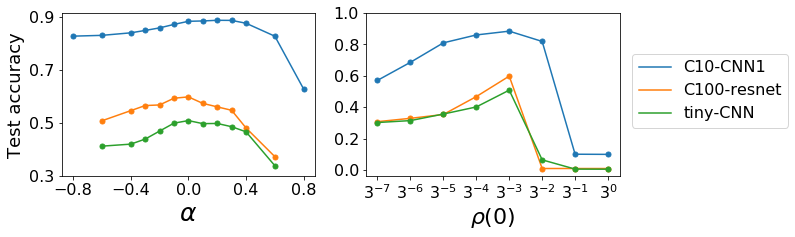

In [116]:
mpld3.disable_notebook()
matplotlib.rcParams.update({'font.size': 16})
f, (ax1,ax2) = plt.subplots(1, 2, figsize = (10,3))

alphas = [-0.8, -0.6, -0.4, -0.3, -0.2, -0.1, 0., 0.1, 0.2, 0.3, 0.4, 0.6, 0.8]
lrs = sorted([3.**(-i) for i in range(0,8)])
for i,task in enumerate(['C10-CNN1', 'C100-resnet', 'tiny-CNN']):
    data = results[task]['SGD_layca']
    
    test_accs = [data[alpha][get_best_lr(data[alpha])]['test_performance'][1] for alpha in alphas]
    train_accs = [data[alpha][get_best_lr(data[alpha])]['history']['history']['acc'][-1] for alpha in alphas]
            
    filtered_test_accs = []
    filtered_alphas = []
    filtered_train_accs = []
    for j,train_acc in enumerate(train_accs):
        if train_acc >0.9:
            filtered_test_accs.append(test_accs[j]) 
            filtered_train_accs.append(train_acc) 
            filtered_alphas.append(alphas[j])
                    
    ax1.plot(filtered_alphas,filtered_test_accs,'C'+str(i)+'-', label = task)
    ax1.plot(filtered_alphas,filtered_test_accs,'C'+str(i)+'.',ms = 10)
    
    data = results[task]['SGD_layca'][0.]
    
    test_accs = [data[lr]['test_performance'][1] for lr in lrs]
    train_accs = [data[lr]['history']['history']['acc'][-1] for lr in lrs]
      
    # filter out parameter values for which train accuracy didn't reach a certain threshold (threshold = 0. for the paper)
    filtered_test_accs = []
    filtered_lrs = []
    filtered_train_accs = []
    for j,train_acc in enumerate(train_accs):
        if train_acc >0.:
            filtered_test_accs.append(test_accs[j]) 
            filtered_train_accs.append(train_acc) 
            filtered_lrs.append(lrs[j])
    log_lrs = [m.log(lr,3) for lr in filtered_lrs]
                    
    ax2.plot(log_lrs,filtered_test_accs,'C'+str(i)+'-', label = task)
#     ax2.plot(log_lrs,filtered_train_accs,'C'+str(i)+'--', label = task)
    ax2.plot(log_lrs,filtered_test_accs,'C'+str(i)+'.',ms = 10)
    
ax2.set_xlabel(r'$\rho (0)$',fontsize=22)
ax1.set_ylabel('Test accuracy',fontsize=18)
ax2.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax2.set_xticks(sorted(log_lrs))
ax2.set_xticklabels([r'$3^{-7}$',r'$3^{-6}$',r'$3^{-5}$',r'$3^{-4}$',r'$3^{-3}$',r'$3^{-2}$',r'$3^{-1}$',r'$3^{0}$'])
    
ax1.set_xlabel(r'$\alpha$',fontsize=25)
# ax2.set_ylabel('Test accuracy',fontsize=18)
ax1.set_yticks([0.3,0.5,0.7,0.9])
ax1.set_xticks(np.arange(-0.8,0.8+0.01, step=0.4))
ax2.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0.)

plt.savefig('figures/exploration_accuracies.eps',format='eps', dpi=200, bbox_inches="tight")

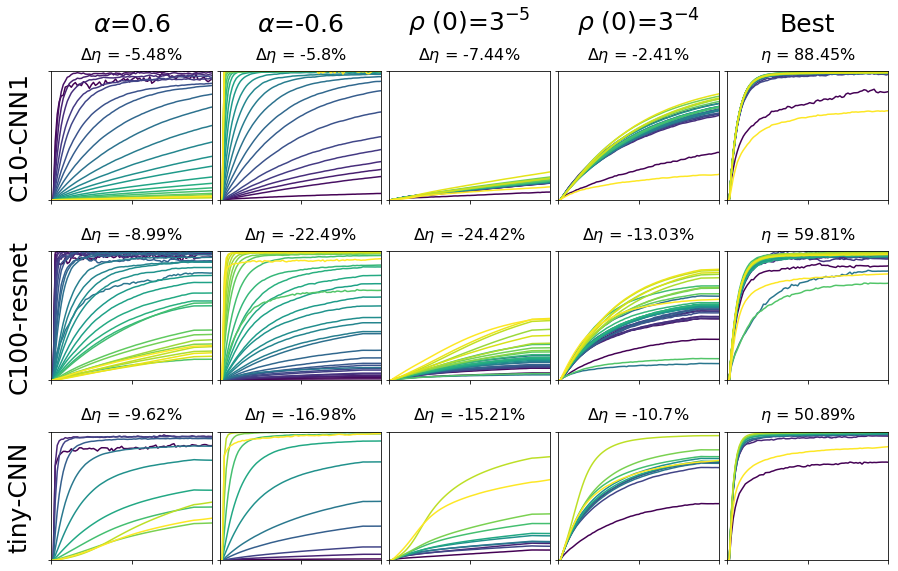

In [8]:
tasks = ['C10-CNN1','C100-resnet','tiny-CNN']
f, axes = plt.subplots(len(tasks), 5, figsize = (15,3*len(tasks)))
axes = np.array([axes]) if len(tasks) == 1 else axes
matplotlib.rcParams.update({'font.size': 15})

for i,task in enumerate(tasks):
    ref_performance = results[task]['SGD_layca'][0.][3**-3]['test_performance'][1]
    for j,alpha in enumerate([-0.6,0.6]):
        data = results[task]['SGD_layca'][alpha]
        
        plot_layerwise_angle_deviation_curves(data[get_best_lr(data)]['ladc'], ax = axes[i,j])

        axes[i,j].set_xlabel('')
        axes[i,j].set_ylabel('')
        axes[i,j].set_yticklabels([''])
        axes[i,j].set_xticklabels([''])
        axes[i,j].set_xlim([0,80])
        axes[i,j].set_xticks([0,40,80])
            
        axes[i,j].set_title('$\Delta \eta$ = '+str(round((data[get_best_lr(data)]['test_performance'][1]-ref_performance)*100,2))+'%',
                           size = 16, y=1.05)

    for j,lr in enumerate([3**-5,3**-4]):
        data = results[task]['SGD_layca'][0.]
        
        plot_layerwise_angle_deviation_curves(data[lr]['ladc'], ax = axes[i,j+2])
        
        axes[i,j+2].set_xlabel('')
        axes[i,j+2].set_ylabel('')
        axes[i,j+2].set_xticklabels([''])
        axes[i,j+2].set_yticklabels([''])
        axes[i,j+2].set_xlim([0,80])
        axes[i,j+2].set_xticks([0,40,80])

        axes[i,j+2].set_title('$\Delta \eta$ = '+str(round((data[lr]['test_performance'][1]-ref_performance)*100,2))+'%',
                           size = 16, y=1.05)

    plot_layerwise_angle_deviation_curves(data[3**-3]['ladc'], ax = axes[i,4])
    axes[i,4].set_title('$\eta$ = '+str(round(data[3**-3]['test_performance'][1]*100,2))+'%',size = 16, y=1.05)
    axes[i,4].set_xlabel('')
    axes[i,4].set_ylabel('')
    axes[i,4].set_xticklabels([''])
    axes[i,4].set_yticklabels([''])
    axes[i,4].set_xlim([0,80])
    axes[i,4].set_xticks([0,40,80])
    
    pad = 5
    axes[i,0].annotate(task, xy=(0, 0.5), xytext=(-axes[i,0].yaxis.labelpad - pad, 0),
                    xycoords=axes[i,0].yaxis.label, textcoords='offset points',
                    size=25, ha='right', va='center',rotation=90)
    
for j in range(5):
    title = [r'$\alpha$=0.6',r'$\alpha$=-0.6',r'$\rho$ (0)=$3^{-5}$',r'$\rho$ (0)=$3^{-4}$','Best']
    pad = 40
    size = 25
    axes[0,j].annotate(title[j], xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=size, ha='center', va='baseline')
    
axes[len(tasks)-1,0].set_xticks([0,40,80])
axes[len(tasks)-1,0].set_xlim([0,80])

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.4)

plt.savefig('figures/exploration_curves_big.png',format='png', dpi=200, bbox_inches="tight")

In [11]:
tasks = ['C10-CNN1','C100-resnet','tiny-CNN']

for i,task in enumerate(tasks):
    performances = []
    for j,alpha in enumerate([-0.6,0.6]):
        data = results[task]['SGD_layca'][alpha]
        performances.append(round(data[get_best_lr(data)]['history']['history']['acc'][-1],4))

    for j,lr in enumerate([3**-5,3**-4]):
        data = results[task]['SGD_layca'][0.]
        performances.append(round(data[lr]['history']['history']['acc'][-1],4))
        
    performances.append(round(data[3**-3]['history']['history']['acc'][-1],4))

    print(performances)

[1.0, 0.9955, 1.0, 1.0, 0.9999]
[0.9738, 0.979, 0.9987, 0.9999, 0.9975]
[0.9998, 0.9864, 0.9997, 0.9997, 0.9891]


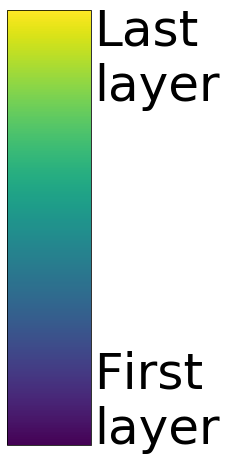

In [20]:
f,ax = plt.subplots(1, figsize = (3,8))
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.get_cmap('viridis'), 
                                       ticks = [0.11,0.9],
                                       orientation='vertical')
# cb1.set_label('Layer depth', fontsize = 35)
cb1.ax.set_yticklabels(['First\nlayer','Last\nlayer'], fontsize = 50) 
cb1.ax.tick_params(axis=u'both', which=u'both',length=0)

box = cb1.ax.get_position()
cb1.ax.set_position([box.x0, box.y0,
                 box.width*0.5, box.height])

plt.savefig('../colorbar.png',format='png', dpi=200, bbox_inches="tight")